In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [58]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys 
sys.path.append('../../src')

In [59]:
import scanpy as sc

In [60]:
import sys
sys.path.append('/Users/koush/Projects/SpaceOracle/src/')
sys.path.append('/Users/koush/Projects/Banksy_py')
import celloracle as co

In [61]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq.h5ad')
adata

AnnData object with n_obs × n_vars = 23409 × 3311
    obs: 'cell_type', 'cell_type_int', 'seurat_clusters', 'umap_1', 'umap_2', 'author_cell_type'
    uns: 'cell_thresholds', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_umap', 'spatial', 'spatial_unscaled'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [62]:
# sc.pl.embedding(adata, 
#         basis='spatial', ncols=2,
#         color=['Tbx6', 'Foxn1', 'Sox2', 'Wnt3a', 'Fgf8', 'Pax6'], layer='imputed_count')
# plt.show()

In [63]:
adata.to_df(layer='imputed_count').values.max()

5.029922075676621

In [64]:
%matplotlib inline

In [65]:
from spaceoracle.tools.network import RegulatoryFactory
co_grn = RegulatoryFactory(
    colinks_path='/Users/koush/Desktop/training_data/mouse_brain_wt_slideseq_colinks.pkl',
    annot='cell_type_int'
)

In [66]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

estimator = SpatialCellularProgramsEstimator(
    adata, 
    target_gene='Foxn1', 
    cluster_annot='cell_type_int',
    radius=200, 
    contact_distance=30,
    grn=co_grn,
)

In [67]:
# estimator.plot_modulators()

In [96]:
estimator.fit(num_epochs=10, learning_rate=5e-3, 
    score_threshold=0.2, l1_reg=1e-9, estimator='lasso')

Fitting Foxn1 with 1131 modulators
	44 Transcription Factors
	987 Ligand-Receptor Pairs
	100 TranscriptionFactor-Ligand Pairs
0: 0.2568 | 0.7818
1: 0.2525 | 0.7801
2: x.xxxx | 0.5578
3: x.xxx* | 0.0597
4: x.xxxx | 0.2797
5: x.xxx* | 0.0861
6: x.xxxx | 0.5115
7: x.xxx* | 0.0518
8: x.xxxx | 0.4895
9: x.xxx* | 0.1277
10: x.xxx* | 0.1406
11: 0.3278 | 0.4303
12: x.xxxx | 0.1664
13: x.xxxx | 0.2397


In [98]:
betadata = estimator.betadata

In [40]:
adata.obs[['cell_type_int', 'cell_type']].drop_duplicates()

,cell_type_int,cell_type
201112_04_CATCATTAATGGGA,0,Amnion mesoderm early
201112_04_TCTTGACCAAGGGC,7,Neural tube
201112_04_CCCGMSTTCCAAGG,4,Heart
201112_04_CAGAGAHAAAGCGA,2,Angioblasts
201112_04_ACGACTTGAGTATT,3,Brain
201112_04_GCCGTCCAGCCGCT,12,Secondary heart field (SHF)
201112_04_CCATCTATCAGCCA,13,Somites
201112_04_GCCCGCTTAGCCCG,10,Preplacodal ectoderm
201112_04_CGTAGGGACATAAC,8,Neuromesodermal Progenitors
201112_04_CGACCTTCAACAGC,9,Pharyngeal arch


In [19]:
pd.DataFrame({f'cluster_{i}': estimator.models[i].anchors.cpu().numpy()[1:] 
    for i in range(len(estimator.models))}, index=estimator.modulators)['cluster_3'].loc[
        estimator.regulators].sort_values(
        ascending=False, key=abs).head(20)

Pax8     -3.447659
Irf1      2.608952
Foxe1    -2.192187
Six5      2.052267
Arntl2    1.552688
Stat1     1.540473
Zbtb7b    1.364665
Elf1      1.285048
Wt1      -1.137516
Sp8       0.998582
Foxa2     0.790064
Egr1     -0.738223
Klf14     0.719406
Rarg     -0.710974
Nfya      0.657669
Foxd3    -0.651645
Sp6       0.583733
Hes7     -0.556903
Tfap2a    0.533543
Id4       0.517596
Name: cluster_3, dtype: float32

In [23]:
from spaceoracle.plotting.cartography import xy_from_adata

xy = xy_from_adata(estimator.adata)

/var/folders/jr/19l2mwvs76v4rv5vy8j4vrch0000gn/T/ipykernel_10673/2201587671.py:19: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  scatter2 = sns.scatterplot(


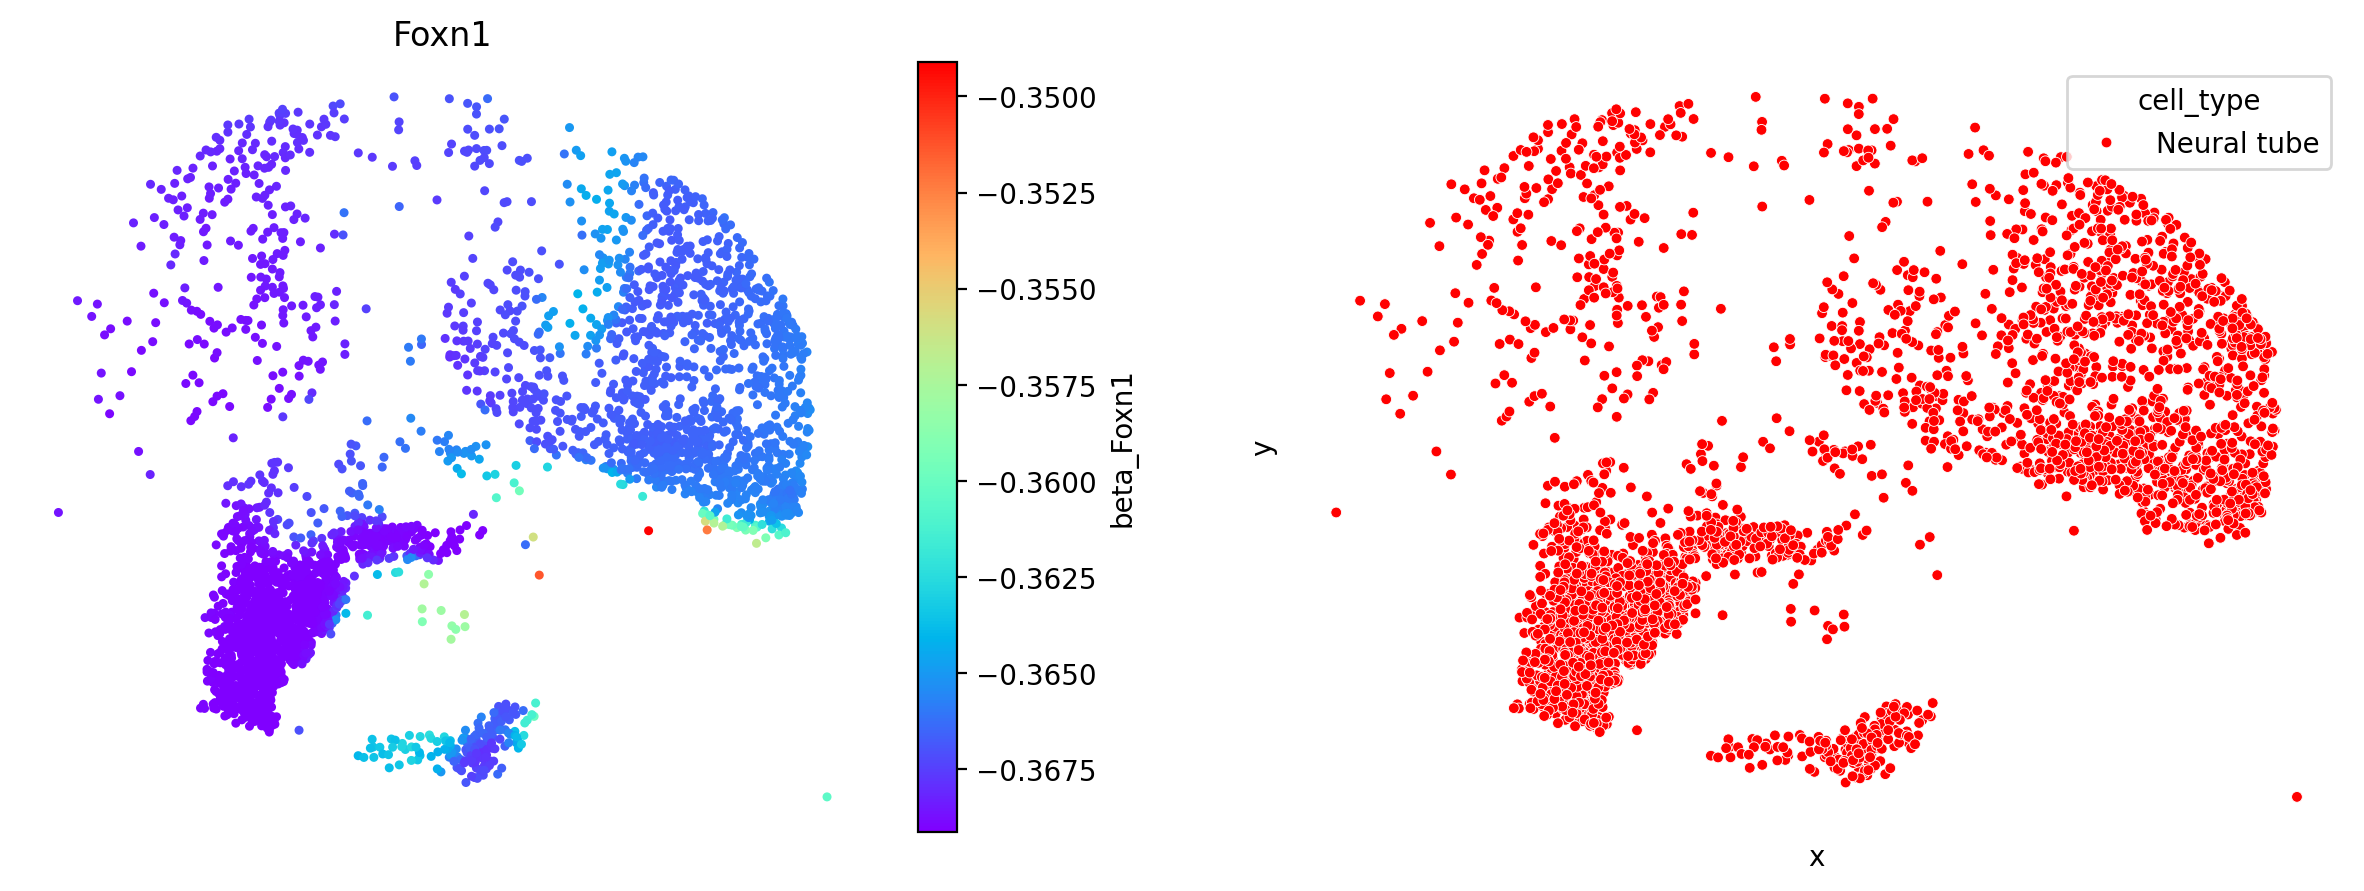

In [29]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
cmap = 'rainbow'
selected = 'Foxn1'
data = betadata.join(estimator.adata.obs[['cell_type_int', 'cell_type']]).join(xy).query(
    'cell_type_int.isin([7])')[
    ['x', 'y', f'beta_{selected}', 'cell_type']].join(estimator.train_df[[f'{selected}']])

data.cell_type = data.cell_type.astype(str)

scatter1 = ax[0].scatter(
    data['x'],
    data['y'], 
    c=data[f'beta_{selected}'],
    s=5,
    cmap=cmap
)
f.colorbar(scatter1, ax=ax[0], label=f'beta_{selected}')

scatter2 = sns.scatterplot(
    data=data,
    x='x',
    y='y',
    hue='cell_type',
    s=15,
    legend=True,
    palette=['red', 'green', 'blue'],
    ax=ax[1],
)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    for spine in ['top', 'right', 'left', 'bottom']:
        a.spines[spine].set_visible(False)
        
ax[0].set_title(selected)
plt.show()

In [28]:
adata.obs[['cell_type_int', 'cell_type']].drop_duplicates()

,cell_type_int,cell_type
201112_04_CATCATTAATGGGA,0,Amnion mesoderm early
201112_04_TCTTGACCAAGGGC,7,Neural tube
201112_04_CCCGMSTTCCAAGG,4,Heart
201112_04_CAGAGAHAAAGCGA,2,Angioblasts
201112_04_ACGACTTGAGTATT,3,Brain
201112_04_GCCGTCCAGCCGCT,12,Secondary heart field (SHF)
201112_04_CCATCTATCAGCCA,13,Somites
201112_04_GCCCGCTTAGCCCG,10,Preplacodal ectoderm
201112_04_CGTAGGGACATAAC,8,Neuromesodermal Progenitors
201112_04_CGACCTTCAACAGC,9,Pharyngeal arch


In [103]:
betadata[[i for i in betadata.columns if 'Shh' in i]].mean()

beta_Shh$Ptch1   -1.841244e-04
beta_Shh$Smo     -5.401439e-05
beta_Shh$Ptch2    1.224366e-05
beta_Shh#Zic1     8.865427e-07
dtype: float32